In [7]:
import os
import zipfile
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import dense_to_sparse
from six.moves import urllib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from torch_geometric_temporal.signal import StaticGraphTemporalSignal

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h


In [9]:


class BICIMADloader(object):
    """A traffic forecasting dataset based on Los Angeles
    Metropolitan traffic conditions. The dataset contains traffic
    readings collected from 207 loop detectors on highways in Los Angeles
    County in aggregated 5 minute intervals for 4 months between March 2012
    to June 2012.

    For further details on the version of the sensor network and
    discretization see: `"Diffusion Convolutional Recurrent Neural Network:
    Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_
    """

    def __init__(self, raw_data_dir, raw_data_name, adj_mat_name):
        self.raw_data_dir = raw_data_dir
        self.raw_data_name = raw_data_name
        self.adj_mat_name = adj_mat_name
        self._load_data()

    
    def _load_data(self):
        #loads data, already preprocessed and normalized!
        A = np.load(os.path.join(self.raw_data_dir, self.adj_mat_name))
        X = np.load(os.path.join(self.raw_data_dir, self.raw_data_name)).transpose(
            (1, 2, 0)
        ).astype(np.float32)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)
        

    def _get_edges_and_weights(self):
        #gets adjacency matrix and transforms it to correct format
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self,target_variable,slide = 1, num_timesteps_in: int = 24, num_timesteps_out: int = 24):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the average traffic speed using num_timesteps_in to predict the
        traffic conditions in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """
        indices = [
            (i*slide, i*slide + (num_timesteps_in + num_timesteps_out))
            for i in range(int((self.X.shape[2] - (num_timesteps_in + num_timesteps_out))/slide+1))
        ]

        # Generate observations
        features, target = [], []
        if target_variable == "plugs":
            target_index = 0
        if target_variable == "unplugs":
            target_index = 1
        for i, j in indices:
            #it assumes that first column will always be the target
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, target_index, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target

    def get_dataset(
        self, target_variable, slide = 1,num_timesteps_in: int = 24, num_timesteps_out: int = 24
    ) -> StaticGraphTemporalSignal:
        """Returns data iterator for METR-LA dataset as an instance of the
        static graph temporal signal class.

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                forecasting dataset.
        """
        self._get_edges_and_weights()
        self._generate_task(target_variable,slide,num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset


In [10]:
class RMSELoss(torch.nn.Module):
        def __init__(self):
            super(RMSELoss,self).__init__()

        def forward(self,x,y):
            criterion = nn.MSELoss(reduction="mean")
            loss = torch.sqrt(criterion(x, y))
            return loss

ME HE CARGADO EL MODELO DE INNOVA PLUG

### Saving results for comparison
we will create the following dataframes:
- Metrics results. Here we will save: model (model_name), target, timeperiod(dataframe), breakout(split), rmse, mae, r2
- predictions over 2022: test_time,	number,	week_index,	test_plugs_actual, test_plugs_pred, test_plugs_pred_weather_lag, test_unplugs_actual, test_unplugs_pred_weather_lag, test_unplugs_pred. We will need to merge the original dataframes to obtain the number, test_time and number, and we will need to fill with 0s the weeks that are in the test set but are not predicted due to the window style.
- predictions over INNOVA comparison set: test_time, number, week_index, test_plugs_actual, test_plugs_pred, test_unplugs_actual, test_unplugs_pred

In [106]:
def get_predictions_labels(dataset, target, split,device):
    model_path = os.path.join("..","checkpoints",dataset+"_"+target+"_checkpoint.pth.tar")
    checkpoint = torch.load(model_path)
    model = checkpoint["model"]


    loader = BICIMADloader(raw_data_dir=os.path.join("..","GNN_data"), raw_data_name=split+"_GNN_"+dataset+"_std.npy",adj_mat_name="adj_mat.npy")
    test_dataset = loader.get_dataset(target_variable=target,slide=168,num_timesteps_in=168, num_timesteps_out=168)
    predictions = []
    labels = []
    model.eval()
    step = 0
    horizon = test_dataset.snapshot_count

    for i,snapshot in enumerate(test_dataset):
        print(f"evaluated week {i+1}/{test_dataset.snapshot_count} of {dataset}, predicting {target} in {split} set")
        snapshot = snapshot.to(device)
        # Get predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Store for analysis below
        labels.append(snapshot.y)
        predictions.append(y_hat)
        step += 1
        if step >= horizon:
            break
    return predictions,labels

def calc_metrics(predictions, labels):
    rmse = mean_squared_error(predictions[:-1], labels[1:], squared = False)
    mae = mean_absolute_error(predictions[:-1], labels[1:])
    r2 = r2_score(labels[1:],predictions[:-1])
    return rmse, mae, r2

In [112]:
# Store for analysis
device = torch.device("cuda")

datasets = ["2022","2022_weather_lagged","innova"]
targets = ["plugs","unplugs"]
splits = ["test"]

metrics_results = pd.DataFrame(columns=["model", "target", "timeperiod", "breakout", "rmse", "mae", "r2"])

prediction_dataframes = {}

for dataset in datasets:
     timeperiod = "all_of_"+dataset if "2022" in dataset else "INNOVA_comparison"

     
     results_dict = {}

     for target in targets:
          for split in splits:
               #flatten_predictions = np.empty()
               predictions, labels = get_predictions_labels(dataset=dataset, target=target, split=split,device=device)
               predictions = np.concatenate(np.asarray([pred.detach().cpu().numpy().transpose().flatten() for pred in predictions]))
               labels = np.concatenate(np.asarray([lab.detach().cpu().numpy().transpose().flatten() for lab in labels]))

               rmse, mae, r2 = calc_metrics(predictions, labels)

               new_row = {"model": "GNN", "target": target, "timeperiod": timeperiod, "breakout": split, "rmse": rmse, "mae": mae, "r2": r2}

               # Append the new row to the DataFrame
               metrics_results = metrics_results.append(new_row, ignore_index=True)

               if split == "test":
                    results_dict["prediction_"+target] = predictions
                    results_dict["true_value_"+target] = labels
               

     prediction_dataframes[dataset] = pd.DataFrame(results_dict)



evaluated week 1/51 of 2022, predicting plugs in test set
evaluated week 2/51 of 2022, predicting plugs in test set
evaluated week 3/51 of 2022, predicting plugs in test set
evaluated week 4/51 of 2022, predicting plugs in test set
evaluated week 5/51 of 2022, predicting plugs in test set
evaluated week 6/51 of 2022, predicting plugs in test set
evaluated week 7/51 of 2022, predicting plugs in test set
evaluated week 8/51 of 2022, predicting plugs in test set
evaluated week 9/51 of 2022, predicting plugs in test set
evaluated week 10/51 of 2022, predicting plugs in test set
evaluated week 11/51 of 2022, predicting plugs in test set
evaluated week 12/51 of 2022, predicting plugs in test set
evaluated week 13/51 of 2022, predicting plugs in test set
evaluated week 14/51 of 2022, predicting plugs in test set
evaluated week 15/51 of 2022, predicting plugs in test set
evaluated week 16/51 of 2022, predicting plugs in test set
evaluated week 17/51 of 2022, predicting plugs in test set
evalua

In [113]:
metrics_results

,model,target,timeperiod,breakout,rmse,mae,r2
0,GNN,plugs,all_of_2022,test,2.380012,1.581805,0.156854
1,GNN,unplugs,all_of_2022,test,2.455921,1.636079,0.150116
2,GNN,plugs,all_of_2022_weather_lagged,test,2.367441,1.573438,0.172066
3,GNN,unplugs,all_of_2022_weather_lagged,test,2.472204,1.642776,0.145168
4,GNN,plugs,INNOVA_comparison,test,4.494258,2.939610,0.092008
5,GNN,unplugs,INNOVA_comparison,test,4.465606,2.957699,0.091129


In [114]:
predictions_2022_weather_lagged = prediction_dataframes["2022_weather_lagged"]
predictions_2022 = prediction_dataframes["2022"]
predictions_innova = prediction_dataframes["innova"]


In [115]:
# putting 2022 predictions with weather lagged predictions
nan_rows = pd.DataFrame(np.nan, index=np.arange(len(predictions_2022)-len(predictions_2022_weather_lagged)), columns=predictions_2022.columns)
predictions_2022_weather_lagged_adapted = pd.concat([nan_rows,predictions_2022_weather_lagged]).reset_index(drop=True)
predictions_2022_weather_lagged_adapted.columns = [column+"_weather_lagged" for column in predictions_2022_weather_lagged_adapted.columns]

In [116]:
predictions_2022_complete = pd.concat([predictions_2022,predictions_2022_weather_lagged_adapted],axis=1)

In [128]:
data_2022 = pd.read_csv(os.path.join("data_bicimad","preprocessed","test_GNN_2022_no_standarized.csv"))
data_innova = pd.read_csv(os.path.join("data_bicimad","preprocessed","test_GNN_innova_no_standardized.csv"))

In [58]:
def fill_nans(df_data, df_predictions):
    # filling the first week of the test set with nans so that length matches with the test set dataframes
    nan_rows = pd.DataFrame(np.nan, index=np.arange(len(df_data)-len(df_predictions)), columns=df_predictions.columns)
    df_predictions_adapted = pd.concat([nan_rows,df_predictions]).reset_index(drop=True)
    # putting together dataset and predictions
    df_data_predictions = pd.concat([df_data,df_predictions_adapted], axis = 1)
    return df_data_predictions


In [138]:
data_2022_with_predictions = fill_nans(data_2022,predictions_2022_complete)
data_innova_with_predictions = fill_nans(data_innova,predictions_innova)

In [141]:
# confirming predictions are aligned with df
print((data_2022_with_predictions["plugs_count"][57120:] != data_2022_with_predictions["true_value_plugs"][57120:]).sum())
print((data_2022_with_predictions["plugs_count"][57120:] != data_2022_with_predictions["true_value_plugs_weather_lagged"][57120:]).sum())

print((data_2022_with_predictions["unplugs_count"][57120:] != data_2022_with_predictions["true_value_unplugs"][57120:]).sum())
print((data_2022_with_predictions["unplugs_count"][57120:] != data_2022_with_predictions["true_value_unplugs_weather_lagged"][57120:]).sum())

# confirming predictions are aligned with df
print((data_innova_with_predictions["plugs_count"][28560:] != data_innova_with_predictions["true_value_plugs"][28560:]).sum())
print((data_innova_with_predictions["unplugs_count"][28560:] != data_innova_with_predictions["true_value_unplugs"][28560:]).sum())


0
0
0
0
0
0


In [142]:
data_2022_with_predictions.to_csv(os.path.join("..","results","predictions","GNN_data_2022_with_predictions.csv"))
data_innova_with_predictions.to_csv(os.path.join("..","results","predictions","GNN_data_innova_with_predictions.csv"))
metrics_results.to_csv(os.path.join("..","results","predictions","GNN_metrics_results_no_innova.csv"))


### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [ ]:
preds.shape

(1848,)

### Average over all stations

In [215]:

sensor = 15
#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred.detach().cpu().numpy() for pred in predictions])
preds=preds.reshape((170,168*(horizon)))
preds = np.sum(preds, axis=0)

labs = np.asarray([lab.detach().cpu().numpy() for lab in labels])
labs=labs.reshape((170,168*(horizon)))
labs = np.sum(labs, axis=0)


In [143]:
data_innova_with_predictions.columns

Index(['Unnamed: 0', 'activate', 'name', 'reservations_count', 'total_bases',
       'free_bases', 'number', 'no_available', 'address', 'dock_bikes',
       'id_station', 'time', 'year', 'plugs_count', 'unplugs_count',
       'latitude', 'longitude', '83', '86', '87', '88', '89', 'dia_semana',
       'work_day_indicator', 'covid_indicator', 'index', 'year_week_index',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'week_of_year_sin', 'week_of_year_cos',
       'wind_cos', 'wind_sin', 'light0', 'light1', 'light2', 'light3',
       'prediction_plugs', 'true_value_plugs', 'prediction_unplugs',
       'true_value_unplugs'],
      dtype='object')

In [148]:
innova_plugs_hour_aggregation = data_innova_with_predictions[["plugs_count","prediction_plugs","time"]].groupby(by="time").sum().reset_index()

<Axes: ylabel='prediction_plugs'>

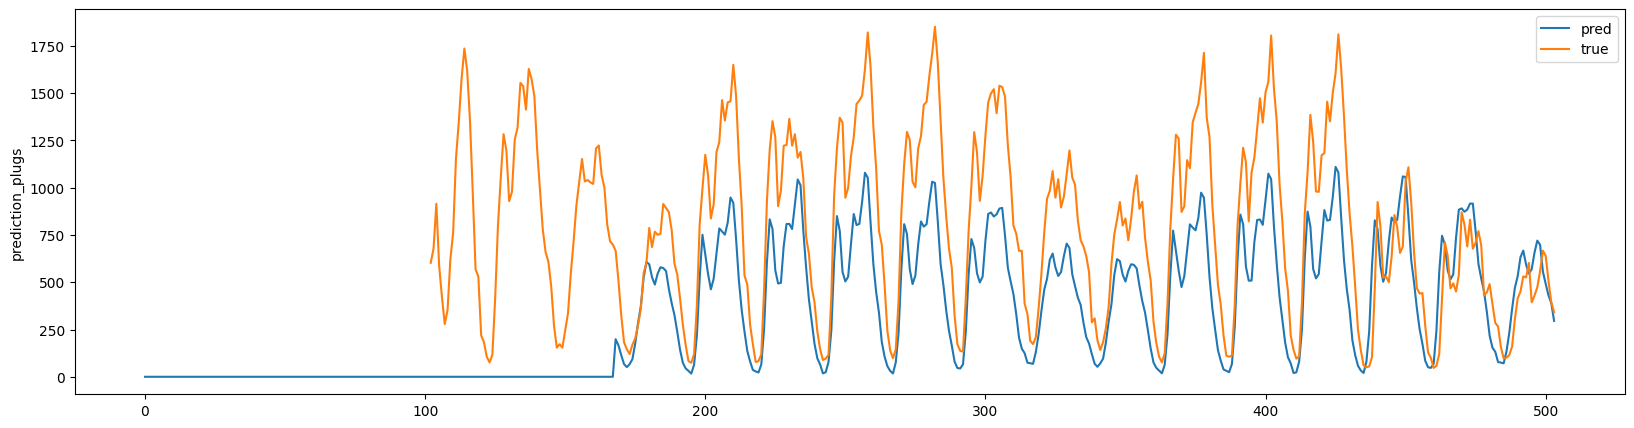

In [154]:
plt.figure(figsize=(20,5))
sns.lineplot(data=innova_plugs_hour_aggregation["prediction_plugs"], label="pred")
sns.lineplot(data=innova_plugs_hour_aggregation["plugs_count"], label="true")

In [159]:
data_2022_plugs_hour_aggregation = data_2022_with_predictions[["plugs_count","prediction_plugs","true_value_plugs","time"]].groupby(by="time").sum().reset_index()

<Axes: ylabel='prediction_plugs'>

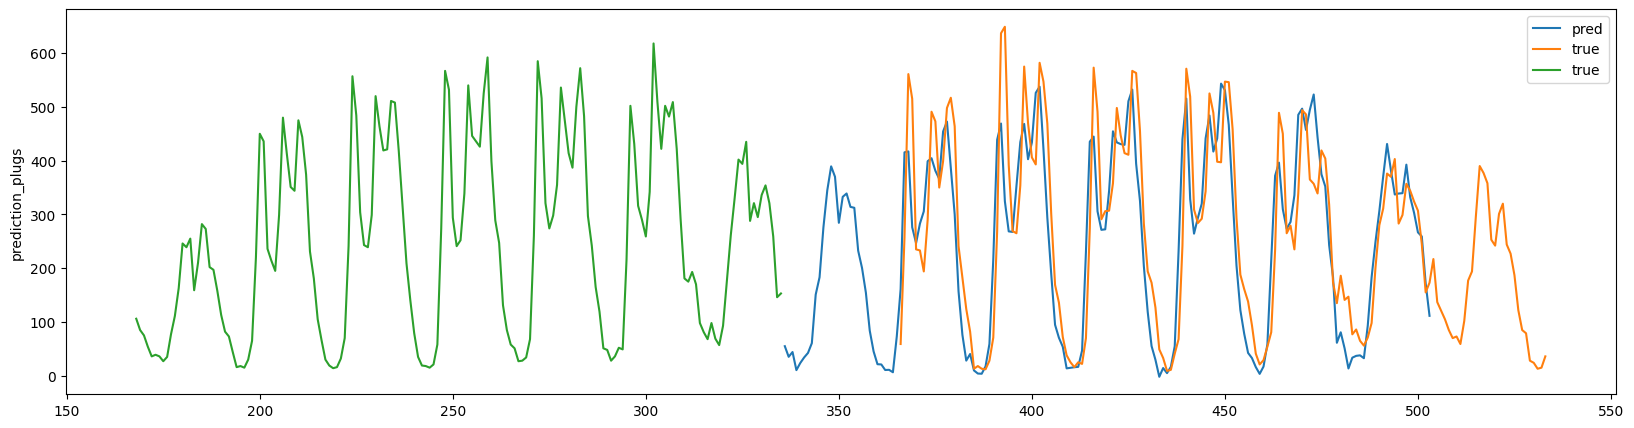

In [165]:
plt.figure(figsize=(20,5))
sns.lineplot(data=data_2022_plugs_hour_aggregation["prediction_plugs"][168*2:3*168], label="pred")
sns.lineplot(data=data_2022_plugs_hour_aggregation["plugs_count"][168*2+30:3*168+30], label="true")
sns.lineplot(data=data_2022_plugs_hour_aggregation["true_value_plugs"][168:2*168], label="true")

<Axes: >

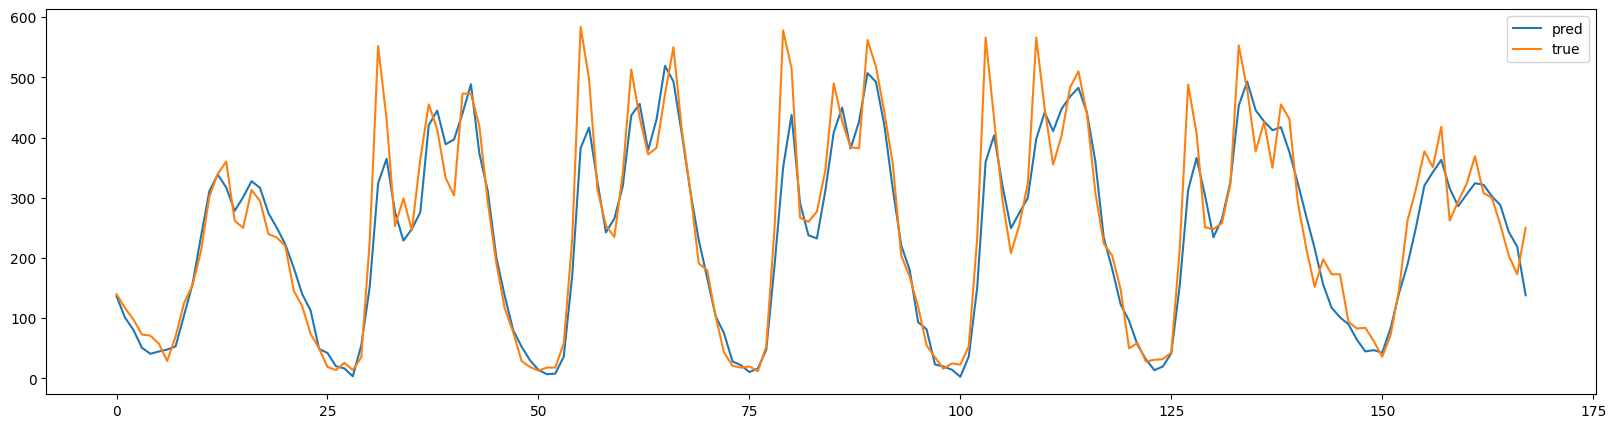

In [164]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*3:4*168], label="pred")
sns.lineplot(data=labs[168*3+1:168*4+1], label="true")

<Axes: >

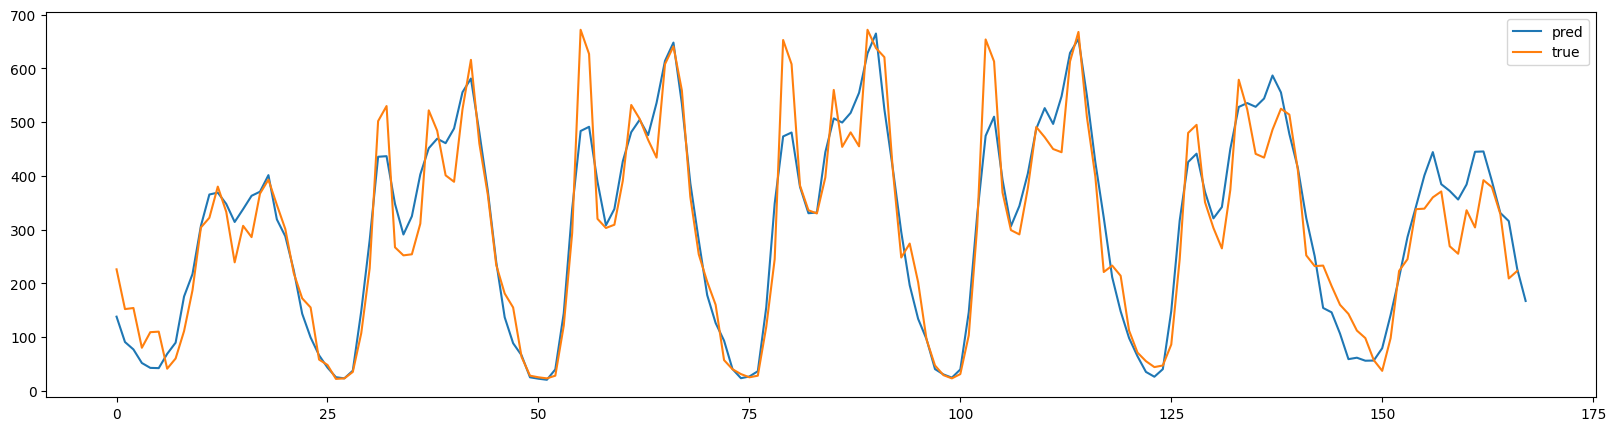

In [111]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[0:168], label="pred")
sns.lineplot(data=labs[1:168], label="true")

<Axes: >

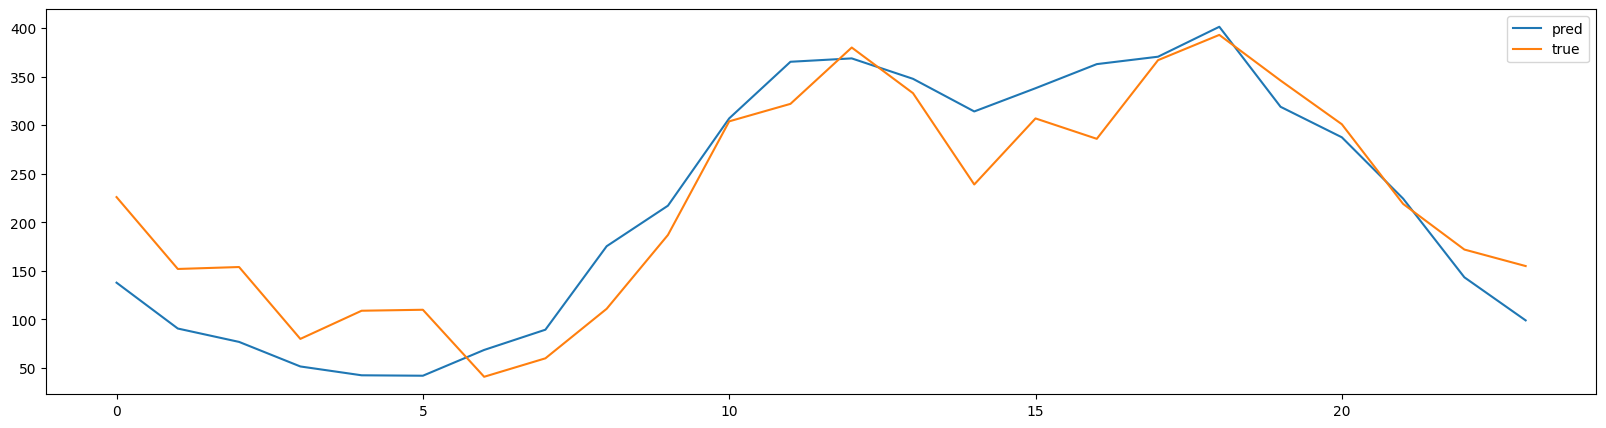

In [109]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[:24], label="pred")
sns.lineplot(data=labs[:24], label="true")

### For a single station

In [ ]:
predictions[0][station].shape

torch.Size([168])

In [90]:
import numpy as np

station = 3

#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred[station].detach().cpu().numpy() for pred in predictions])
preds = preds.reshape(168*(horizon))
labs = np.asarray([lab[station].detach().cpu().numpy() for lab in labels])
labs = labs.reshape(168*(horizon))


<Axes: >

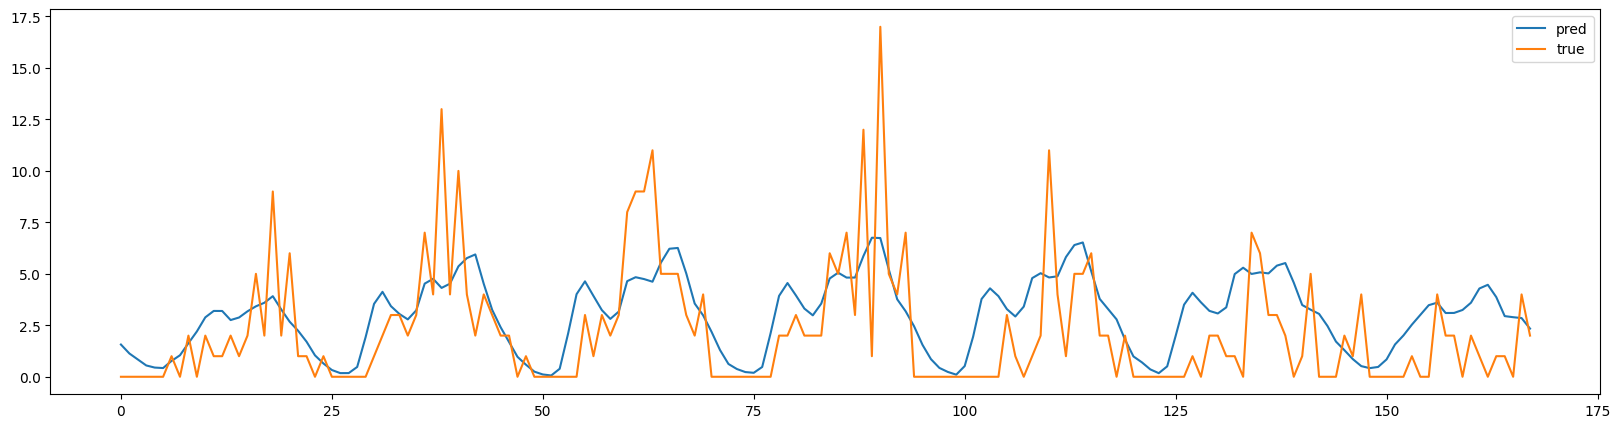

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*0:1*168], label="pred")
sns.lineplot(data=labs[168*0:1*168], label="true")

In [92]:
import numpy as np

station = 25

#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred[station].detach().cpu().numpy() for pred in predictions])
preds = preds.reshape(168*(horizon))
labs = np.asarray([lab[station].detach().cpu().numpy() for lab in labels])
labs = labs.reshape(168*(horizon))


<Axes: >

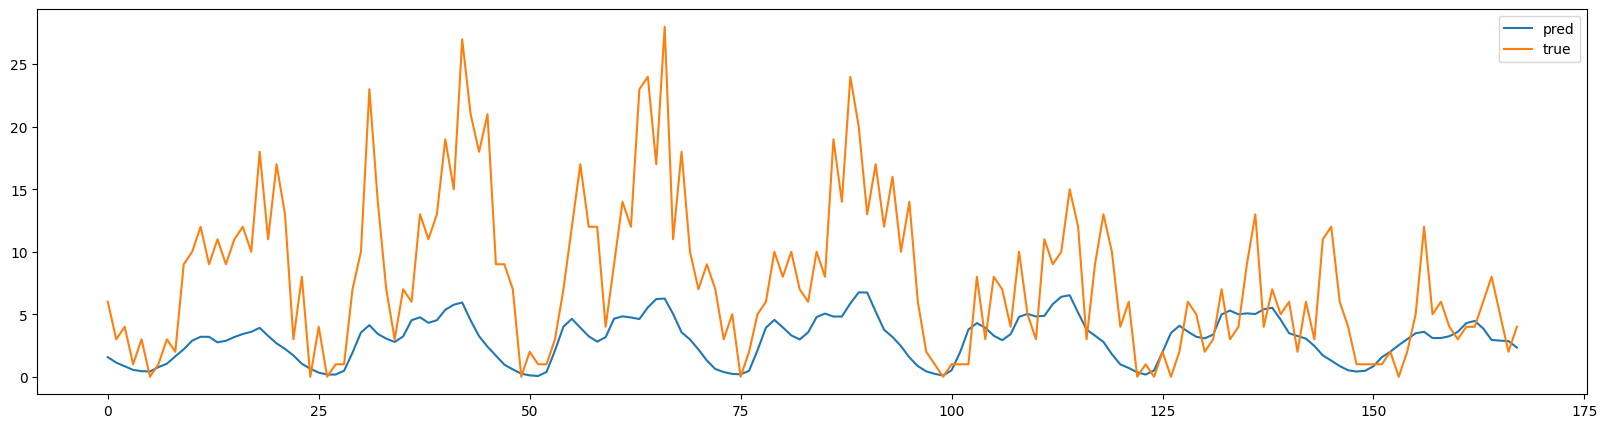

In [93]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*0:1*168], label="pred")
sns.lineplot(data=labs[168*0:1*168], label="true")

In [94]:
import numpy as np

station = 100

#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred[station].detach().cpu().numpy() for pred in predictions])
preds = preds.reshape(168*(horizon))
labs = np.asarray([lab[station].detach().cpu().numpy() for lab in labels])
labs = labs.reshape(168*(horizon))


<Axes: >

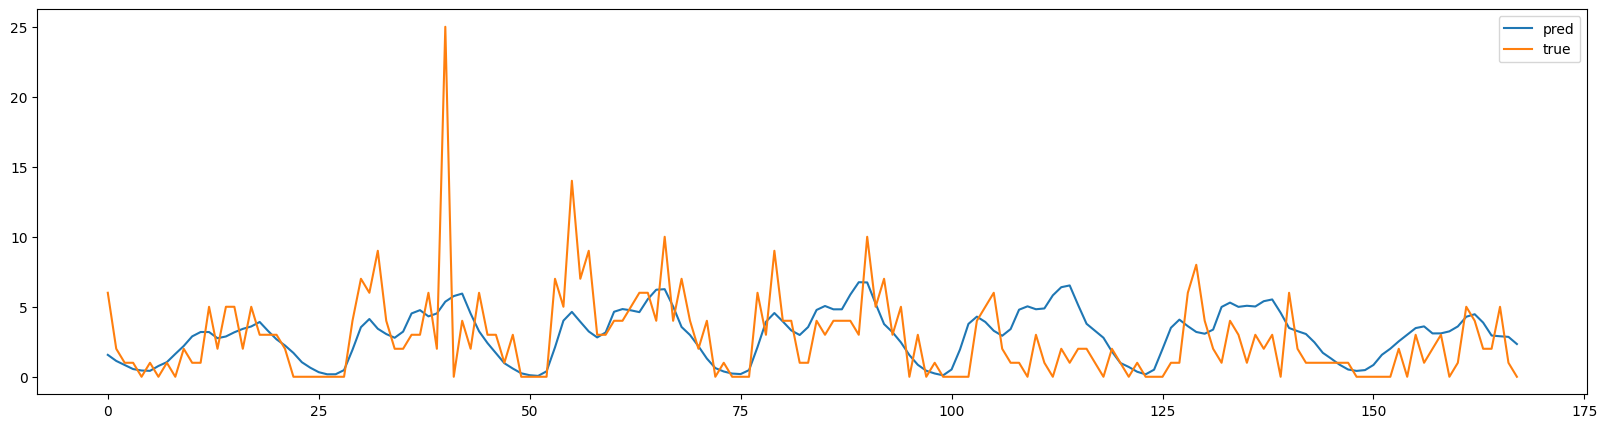

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168*0:1*168], label="pred")
sns.lineplot(data=labs[168*0:1*168], label="true")

Erika's data

In [166]:
predictions_fixed_INNOVA_comparison_test = pd.read_csv(os.path.join("visualization_data","predictions_fixed_INNOVA_comparison_test.csv"))

In [170]:
predictions_fixed_INNOVA_comparison_test

,Unnamed: 0,test_time,number,week_index,test_plugs_pred,test_plugs_actual,test_unplugs_pred,test_unplugs_actual
0,4637090,2021-06-20 00:00:00,10,202125,0.080641,0.0,0.902942,0.0
1,4637257,2021-06-20 00:00:00,97,202125,1.574990,0.0,1.897297,10.0
2,4637258,2021-06-20 00:00:00,98,202125,1.389602,2.0,1.407550,2.0
3,4637259,2021-06-20 00:00:00,99,202125,0.455319,1.0,0.473449,1.0
4,4637260,2021-06-20 00:00:00,168,202125,0.645925,1.0,1.091140,0.0
...,...,...,...,...,...,...,...,...
88699,4725623,2021-07-03 23:00:00,29,202126,2.047585,1.0,1.341989,2.0
88700,4725624,2021-07-03 23:00:00,3,202126,1.261677,4.0,1.241231,1.0
88701,4725625,2021-07-03 23:00:00,30,202126,1.775089,1.0,1.407329,0.0
88702,4725611,2021-07-03 23:00:00,1a,202126,2.539794,2.0,2.332012,3.0


In [174]:
hour_aggregation = predictions_fixed_INNOVA_comparison_test.groupby(by=["test_time"]).agg({"test_plugs_pred":"sum","test_plugs_actual":"sum","test_unplugs_pred":"sum","test_unplugs_actual":"sum",}).reset_index()

<Axes: ylabel='test_plugs_pred'>

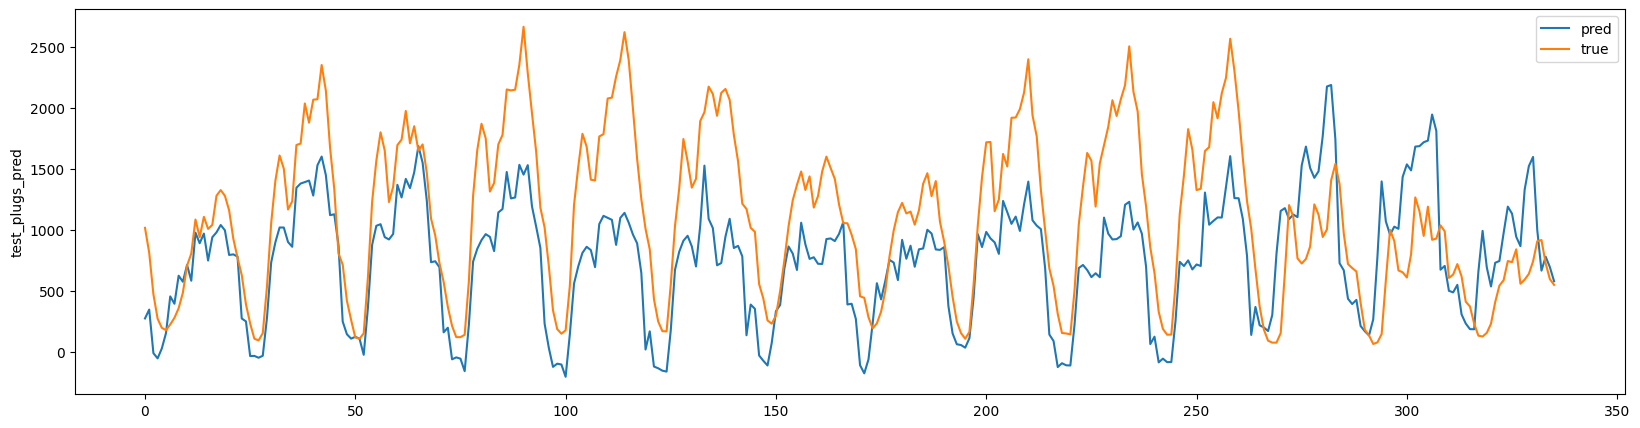

In [175]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=hour_aggregation["test_plugs_pred"], label="pred")
sns.lineplot(data=hour_aggregation["test_plugs_actual"], label="true")

In [176]:
hour_aggregation[hour_aggregation["test_plugs_pred"]<0]

,test_time,test_plugs_pred,test_plugs_actual,test_unplugs_pred,test_unplugs_actual
2,2021-06-20 02:00:00,-7.372056,475.0,450.470604,474.0
3,2021-06-20 03:00:00,-49.918416,275.0,421.556345,275.0
25,2021-06-21 01:00:00,-31.032789,236.0,131.438480,235.0
26,2021-06-21 02:00:00,-29.696079,111.0,156.444437,111.0
27,2021-06-21 03:00:00,-44.812775,97.0,179.284982,97.0
28,2021-06-21 04:00:00,-28.461014,156.0,250.320964,156.0
52,2021-06-22 04:00:00,-20.819478,155.0,276.002051,155.0
73,2021-06-23 01:00:00,-57.563044,216.0,54.298285,215.0
74,2021-06-23 02:00:00,-41.813559,124.0,75.339213,124.0
75,2021-06-23 03:00:00,-52.298489,124.0,85.904795,124.0
